In [ ]:
import geopandas as gpd
import pandas as pd
import os
from pyogrio.errors import DataSourceError

polygon_data = []
for root, dirs, files in os.walk("California_spread_2012_2021"):
    for file in files:
        if file.endswith(".shp"):
            path = os.path.join(root, file)
            try:
                gdf = gpd.read_file(path)
                fire_name = file.split('_')[1]
                if fire_name[0].isdigit():
                    fire_name += " BUTTE LIGHTNING COMPLEX"
                gdf["FIRE_NAME"] = fire_name
                
                if gdf.crs.to_string() != "EPSG:4326":
                    gdf = gdf.to_crs("EPSG:4326")
                
                gdf_projected = gdf.to_crs("EPSG:3857")
                
                centroids = gdf_projected.centroid.to_crs("EPSG:4326")
                gdf["CENTROID_LAT"] = centroids.y
                gdf["CENTROID_LON"] = centroids.x
                
                if gdf.geom_type.iloc[0] in ['Polygon', 'MultiPolygon']:
                    polygon_data.append(gdf)
            except (DataSourceError, OSError) as e:
                print(f"Skipping {file} due to error: {e}")

Skipping 2018_DONNELL_daily.shp due to error: Unable to open California_spread_2012_2021/2018_DONNELL_daily.shx or California_spread_2012_2021/2018_DONNELL_daily.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.


In [ ]:
all_polygons = pd.concat(polygon_data, ignore_index=True)

all_polygons.to_csv("California_fire_data_with_centroids.csv", index=False)

print("Exported data with centroids to California_fire_data_with_centroids.csv")

Exported data with centroids to California_fire_data_with_centroids.csv


In [ ]:
all_polygons['FIRE_NAME'].value_counts()

FIRE_NAME
RED SALMON COMPLEX    97
BLUEJAY               86
CASCADE               84
DIXIE                 84
LIONS                 80
                      ..
DOBBYN 1-57            2
ANGORA                 2
GEORGES                2
HAYNES                 2
SHARP                  2
Name: count, Length: 421, dtype: int64

In [11]:
all_polygons.to_csv('all_polygons.csv', index=False)

In [12]:
all_polygons

,DOY,YYYYMMDD,YEAR,geometry,FIRE_NAME,CENTROID_LAT,CENTROID_LON
0,194.429167,2012/07/12,2012.0,"POLYGON ((-123.33478 40.79685, -123.33012 40.7...",FLAT,40.790442,-123.335819
1,195.412500,2012/07/13,2012.0,"POLYGON ((-123.33958 40.7984, -123.33869 40.80...",FLAT,40.792111,-123.336071
2,196.400000,2012/07/14,2012.0,"POLYGON ((-123.33958 40.7984, -123.33869 40.80...",FLAT,40.792633,-123.334991
3,197.458333,2012/07/15,2012.0,"POLYGON ((-123.33958 40.7984, -123.33869 40.80...",FLAT,40.792755,-123.332730
4,198.445833,2012/07/16,2012.0,"POLYGON ((-123.33958 40.7984, -123.33869 40.80...",FLAT,40.792319,-123.331770
...,...,...,...,...,...,...,...
5843,233.366667,2017/08/21,2017.0,"POLYGON ((-118.30777 36.25553, -118.30689 36.2...",INDIAN,36.247429,-118.295438
5844,301.433333,2020/10/27,2020.0,"POLYGON ((-120.4986 39.00173, -120.49194 39.00...",POINT,39.002256,-120.486900
5845,302.420833,2020/10/28,2020.0,"POLYGON ((-120.4986 39.00173, -120.49231 39.00...",POINT,39.002801,-120.487869
5846,221.383333,2013/08/09,2013.0,"POLYGON ((-117.61414 34.34099, -117.60987 34.3...",SHARP,34.337601,-117.616687


/var/folders/c1/n5n5b61165z68_7_s70mm43h0000gn/T/ipykernel_74963/2033517036.py:35: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right')


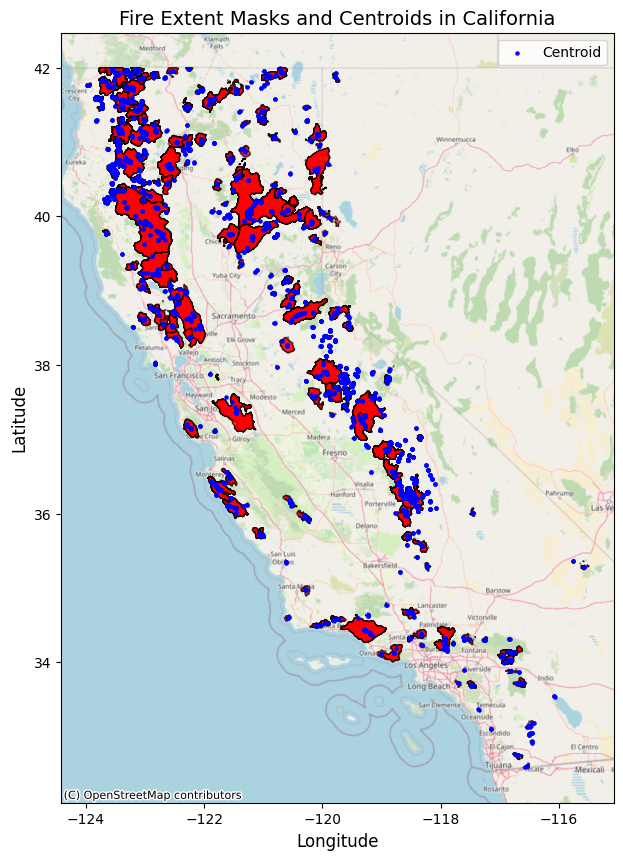

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    all_polygons, 
    geometry=all_polygons['geometry'], 
    crs="EPSG:4326"  # Assuming your data is already in WGS84 (latitude/longitude)
)

# Create a GeoDataFrame for centroids
centroid_gdf = gpd.GeoDataFrame(
    all_polygons, 
    geometry=gpd.points_from_xy(all_polygons['CENTROID_LON'], all_polygons['CENTROID_LAT']),
    crs="EPSG:4326"
)

# Plot polygons and centroids
fig, ax = plt.subplots(figsize=(10, 10))

# Plot fire masks (polygons)
gdf.plot(ax=ax, color='red', alpha=0.5, edgecolor='black', label='Fire Mask (Polygon)')

# Plot centroids
centroid_gdf.plot(ax=ax, color='blue', markersize=5, label='Centroid')

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Add labels and legend
plt.title('Fire Extent Masks and Centroids in California', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(loc='upper right')

plt.show()